<a href="https://colab.research.google.com/github/plthiyagu/Personnel/blob/master/Multivariate_Multi_step_Time_Series_Forecasting_using_Stacked_LSTM_sequence_to_sequence_Autoencoder_in_Tensorflow_2_0_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/?utm_source=feedburner&utm_medium=email&utm_campaign=Feed%3A+AnalyticsVidhya+%28Analytics+Vidhya%29

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [ ]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
#!unzip household_power_consumption.zip  

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/household_power_consumption.zip?raw=true',
               compression='zip',sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df = df.replace('?', np.nan)
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
def fill_missing(values):
  one_day = 60*24
  for row in range(df.shape[0]):
      for col in range(df.shape[1]):
          if np.isnan(values[row][col]):
              values[row,col] = values[row-one_day,col]
df = df.astype('float32')
fill_missing(df.values)
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
daily_df = df.resample('D').sum()
daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [9]:
daily_df.shape, df.shape

((1442, 7), (2075259, 7))

In [10]:
# For this case, let's assume that
# Given past 10 days observation, forecast the next 5 days observations. 
n_past = 10
n_future = 5 
n_features = 7

In [11]:
train_df,test_df = daily_df[1:1081], daily_df[1081:]  # 75% and 25%
train_df.shape,test_df.shape

((1080, 7), (361, 7))

In [12]:
train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [13]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [14]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [15]:
X_test.shape

(347, 10, 7)

In [16]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 43200       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 5, 100)       0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 5, 100)       80400       repeat_vector[0][0]              
                                                                 lstm[0][1]            

In [17]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 10, 100), (N 43200       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 100), (None, 80400       lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 100)       0           lstm_3[0][0]                     
_______________________________________________________________________________________

In [18]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

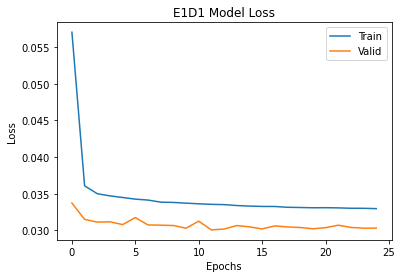

In [19]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

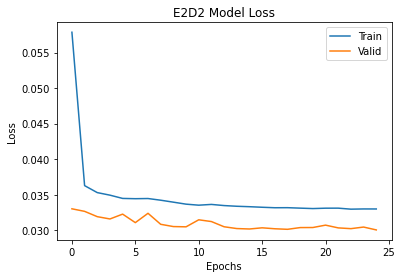

In [20]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [21]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

pred_e1d1=model_e1d1.predict(X_train)
pred_e2d2=model_e2d2.predict(X_train)

In [22]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    
    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [23]:
from sklearn.metrics import mean_absolute_error
 
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
  print()
  print()
  

Global_active_power
Day  1 :
MAE-E1D1 :  248.06471, MAE-E2D2 :  247.15683
Day  2 :
MAE-E1D1 :  260.02914, MAE-E2D2 :  255.32997
Day  3 :
MAE-E1D1 :  270.8711, MAE-E2D2 :  264.53534
Day  4 :
MAE-E1D1 :  275.7502, MAE-E2D2 :  267.27356
Day  5 :
MAE-E1D1 :  280.45746, MAE-E2D2 :  270.8554


Global_reactive_power
Day  1 :
MAE-E1D1 :  29.82177, MAE-E2D2 :  29.75994
Day  2 :
MAE-E1D1 :  31.254345, MAE-E2D2 :  31.423563
Day  3 :
MAE-E1D1 :  31.789198, MAE-E2D2 :  32.117527
Day  4 :
MAE-E1D1 :  32.37818, MAE-E2D2 :  32.44815
Day  5 :
MAE-E1D1 :  32.931885, MAE-E2D2 :  32.532845


Voltage
Day  1 :
MAE-E1D1 :  1209.9615, MAE-E2D2 :  1279.3938
Day  2 :
MAE-E1D1 :  1324.6538, MAE-E2D2 :  1367.0386
Day  3 :
MAE-E1D1 :  1422.1647, MAE-E2D2 :  1452.8722
Day  4 :
MAE-E1D1 :  1505.8552, MAE-E2D2 :  1524.5853
Day  5 :
MAE-E1D1 :  1696.9633, MAE-E2D2 :  1713.8145


Global_intensity
Day  1 :
MAE-E1D1 :  1028.7609, MAE-E2D2 :  1046.7065
Day  2 :
MAE-E1D1 :  1084.5564, MAE-E2D2 :  1081.4958
Day  3 :
MAE-E1D